In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pickle

import MuC.MuC as dg
from MuC import const
from MuC import collider_tools as col
from MuC import detector_tools as det
from MuC import plot_tools as pt
from MuC import const

from MuC.MuC import BINSimulator
from DarkNews import Cfourvec as Cfv


## Load lattice data with Twiss parameters

In [ ]:
def get_gyro_radius(E, B):
    return 3.3e2 * E / B # cm (E in GeV, B in T)

def get_dtheta(s, R):
    return s/R

def propagate(x0, y0, px0, py0, dtheta, s):
    # r = np.sqrt(x0**2 + y0**2)
    theta_p = np.arctan2(py0, px0) 
    p = np.sqrt(px0**2 + py0**2)
    pxf = p * np.cos(theta_p - dtheta)
    pyf = p * np.sin(theta_p - dtheta)

    if dtheta == 0:
        return x0 + s*np.cos(theta_p), y0+s*np.sin(theta_p), pxf, pyf
    else:
        R = s/dtheta
        # coordinates centered around larmor circle
        x0_prime = R * np.cos(np.pi/2 + theta_p)
        y0_prime = R * np.sin(np.pi/2 + theta_p)

        xf_prime = R * np.cos(np.pi/2 + theta_p - dtheta)
        yf_prime = R * np.sin(np.pi/2 + theta_p - dtheta)

        dx = xf_prime - x0_prime
        dy = yf_prime - y0_prime

        
        return x0 + dx, y0 + dy, pxf, pyf
    
def get_lattice_dataframe(filename):
    # Initialize lists to store metadata and column data
    metadata = {}
    columns = []
    data = []

    # Open and read file
    with open(filename, 'r') as file:
        for line in file:
            # Extract metadata lines
            if line.startswith('@'):
                parts = line.split()
                key = parts[1]
                value = " ".join(parts[3:]).strip('"')
                metadata[key] = value
            # Extract column names
            elif line.startswith('*'):
                columns = line.strip().split()[1:]  # Strip and split, and ignore the '*' character
            # Skip format line
            elif line.startswith('$'):
                continue
            # Extract data lines
            else:
                fields = [s.strip('"') for s in line.strip().split()]

                data.append(fields)

    # Validate and filter correct data rows
    correct_data = [row for row in data if len(row) == len(columns)]
    df = pd.DataFrame(correct_data, columns=columns)

    # Assign metadata to the DataFrame's attributes
    df.attrs = metadata

    # Convert numerical columns to appropriate data types
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column], errors='ignore')
        except ValueError:
            pass


    df['bending_magnet'] = (df['ANGLE'] != 0)
    df['GAMMAX']  = (1 + df['ALFX']**2) / df['BETX']
    df['GAMMAY']  = (1 + df['ALFY']**2) / df['BETY']

    n_elements = df.index.size

    df['x'] = np.zeros((n_elements,))
    df['y'] = np.zeros((n_elements,))
    df['px'] = np.zeros((n_elements,))
    df['py'] = np.zeros((n_elements,))

    # Put the initial conditions for the particle momentum
    df.loc[0,'px'] = float(df.attrs['ENERGY'])

    for i in range(0,n_elements):
        if df['L'][i] == 0:
            df.loc[i+1, 'x'], df.loc[i+1, 'y'], df.loc[i+1, 'px'], df.loc[i+1, 'py'] = df['x'][i], df['y'][i], df['px'][i], df['py'][i]
            continue
        else:
            df.loc[i+1, 'x'], df.loc[i+1, 'y'], df.loc[i+1, 'px'], df.loc[i+1, 'py'] = propagate(df['x'][i], df['y'][i], df['px'][i], df['py'][i], dtheta=df['ANGLE'][i], s=df['L'][i])
            
    return df


In [23]:
twiss_file_path_3tev = 'beam-optics/mc3tev_v1.2.tfs'
twiss_file_path_10tev = 'beam-optics/ring_v06.tfs'

df_3tev  = get_lattice_dataframe(twiss_file_path_3tev)
df_10tev = get_lattice_dataframe(twiss_file_path_10tev)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_72126/186781022.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[column] = pd.to_numeric(df[column], errors='ignore')
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_72126/186781022.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bending_magnet'] = (df['ANGLE'] != 0)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_72126/186781022.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

In [24]:
emittance_RMS = 0.5e-9 # cm
beta_star = 1.5e-3 # m
gamma_factor = 5e3/const.m_mu
area = np.pi*(beta_star * emittance_RMS) * 1e4 # cm^2

Nmu = 1.8e12
f = const.c_LIGHT/8.6688e5
Nmu**2 * f / 4 / area 

1.1888733785474108e+36

## Plotting the lattices

In [43]:
def plot_lattice(df):
    fig, ax = pt.std_fig(figsize=(10, 5))
    # ax.set_xlim(-220, 0)
    # ax.set_xlim(125, 150)
    # ax.set_ylim(-11, 11)
    # ax.scatter(df['x'][~df['bending_magnet']], df['y'][~df['bending_magnet']], marker='|', s=200, color='darkorange', zorder=2)
    # ax.scatter(df['x'][df['bending_magnet']], df['y'][df['bending_magnet']], marker='x', s=200, color='dodgerblue', zorder=2)
    ax.plot(df['x'],df['y'], linewidth=0.5, c='black')

    rect = patches.Rectangle((-6,-6), 12, 12, linewidth=2, edgecolor='black', facecolor='None', hatch='///////') 
    ax.add_patch(rect)


    # Minimum size of linear step
    ds = 0.1 
    # How tall is the magnet for x-y plane
    magnet_thickness = 1
    n_elements = df.index.size
    ds = 0.1
    # for i in list(range(1,100))+list(range(n_elements-100,n_elements)):
    for i in list(range(n_elements-400,n_elements)):
        x, y, s = df['x'][i], df['y'][i], df['L'][i]
        px, py = df['px'][i], df['py'][i]
        theta_p = np.arctan2(py, px)
        dtheta = df['ANGLE'][i]
        r_arc = s/dtheta

        if df['L'][i] > 0:
            n_discrete_bend = max(int(s / ds), 30)
            x0, y0, px0, py0 = x, y, px, py
            for j in range(n_discrete_bend):
                xn, yn, pxn, pyn = propagate(x0, y0, px0, py0, dtheta/n_discrete_bend, s/n_discrete_bend)
                theta_pn = np.arctan2(pyn, pxn)

                if df['KEYWORD'][i] == 'SBEND' or df['KEYWORD'][i] == 'RBEND':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor='dodgerblue', facecolor='dodgerblue', zorder=0.5, alpha=1) 
                elif df['KEYWORD'][i] == 'QUADRUPOLE' or df['KEYWORD'][i] == 'MULTIPOLE' or df['KEYWORD'][i] == 'RCOLLIMATOR':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor='orange', facecolor='orange', zorder=0.51, alpha=1) 
                elif df['KEYWORD'][i] == 'DRIFT':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor='lightgrey', facecolor='lightgrey', zorder=0.5, alpha=1) 

                ax.add_patch(rect)
                x0, y0, px0, py0 = xn, yn, pxn, pyn

    ax.set_ylim(df['y'].min()/2, 10)
    ax.set_xlim(df['x'].min(), 0)

    # if df['KEYWORD'][i] == 'DRIFT':
        # ax.plot([x, x+s*np.cos(theta_p)], [y, y+s*np.sin(theta_p)], color='black', linewidth=2)
            
    fig.savefig(f'plots/beam_optics/lattice_{df.attrs["ENERGY"]}_trajectory.pdf', dpi=500, bbox_inches='tight')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_72126/1433555505.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  r_arc = s/dtheta
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_72126/1433555505.py:26: RuntimeWarning: invalid value encountered in scalar divide
  r_arc = s/dtheta


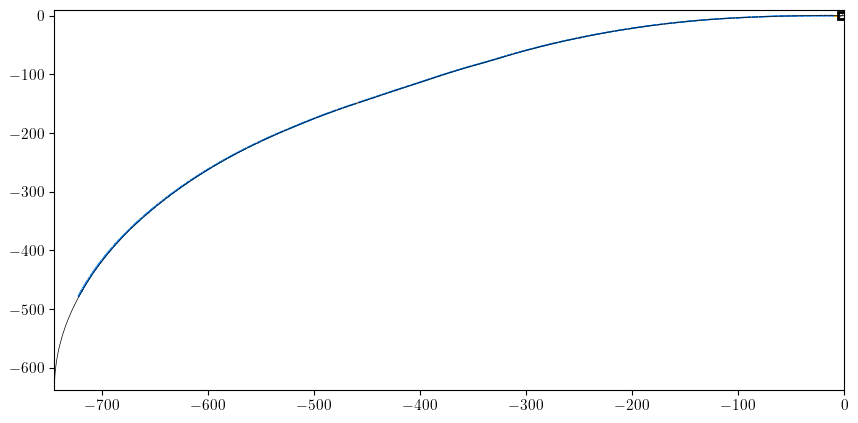

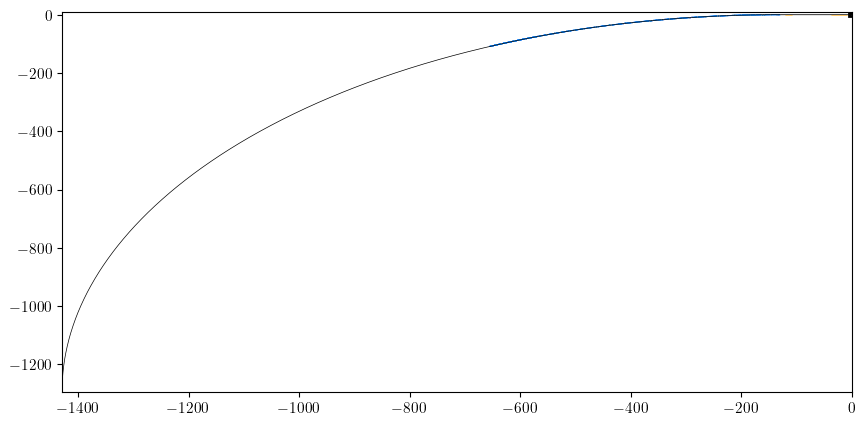

In [44]:
plot_lattice(df_3tev)
plot_lattice(df_10tev)

## Create a smooth curve for the trajectory

In [ ]:

def create_smoothed_lattice(df):

    m_to_cm=100
    n_elements = df.index.size
    # Minimum size of linear step
    ds = 0.005

    # All desired units are cm or seconds or radians
    smooth_curve_x = np.array([])
    smooth_curve_y = np.array([])

    smooth_curve_s = np.array([])
    smooth_curve_t = np.array([])

    smooth_curve_angle_of_central_p = np.array([])

    smooth_curve_beamsize_x = np.array([])
    smooth_curve_beamsize_y = np.array([])

    smooth_curve_beamdiv_x = np.array([])
    smooth_curve_beamdiv_y = np.array([])

    smooth_curve_dispersion_Dx = np.array([])
    smooth_curve_dispersion_Dpx = np.array([])


    for i in range(0,n_elements):
    # for i in list(range(n_elements-200,n_elements)):
        x, y, l = df['x'][i], df['y'][i], df['L'][i]
        s = df['S'][i] - l
        px, py = df['px'][i], df['py'][i]
        theta_p = np.arctan2(py, px) 
        dtheta = df['ANGLE'][i]
        r_arc = l/dtheta

        if df['L'][i] > 0:
            n_discrete_bend = int(l / ds)
            x0, y0, px0, py0 = x, y, px, py
            for j in range(n_discrete_bend):
                xn, yn, pxn, pyn = propagate(x0, y0, px0, py0, dtheta/n_discrete_bend, l/n_discrete_bend)
                theta_pn = np.arctan2(pyn, pxn)

                smooth_curve_s = np.append(smooth_curve_s, (s+ds*j)*m_to_cm)
                smooth_curve_x = np.append(smooth_curve_x, xn*m_to_cm)
                smooth_curve_y = np.append(smooth_curve_y, yn*m_to_cm)
                smooth_curve_angle_of_central_p = np.append(smooth_curve_angle_of_central_p, theta_pn)
                smooth_curve_t = np.append(smooth_curve_t, (s+ds*j)*m_to_cm / const.c_LIGHT )

                smooth_curve_beamsize_x = np.append(smooth_curve_beamsize_x, np.sqrt(emittance_RMS*df['BETX'][i])*m_to_cm)
                smooth_curve_beamsize_y = np.append(smooth_curve_beamsize_y, np.sqrt(emittance_RMS*df['BETY'][i])*m_to_cm)
                
                smooth_curve_beamdiv_x = np.append(smooth_curve_beamdiv_x, np.arctan(np.sqrt(emittance_RMS*df['GAMMAX'][i])))
                smooth_curve_beamdiv_y = np.append(smooth_curve_beamdiv_y, np.arctan(np.sqrt(emittance_RMS*df['GAMMAY'][i])))
                        
                smooth_curve_dispersion_Dx = np.append(smooth_curve_dispersion_Dx, df['DX'][i])
                smooth_curve_dispersion_Dpx = np.append(smooth_curve_dispersion_Dpx, df['DPX'][i])
                
                x0, y0, px0, py0 = xn, yn, pxn, pyn



    lattice_dict = {}
    u = np.linspace(0, 1, len(smooth_curve_s))
    lattice_dict['x'] = interp1d(u, smooth_curve_x, bounds_error=False, fill_value=None)
    lattice_dict['y'] = interp1d(u, smooth_curve_y, bounds_error=False, fill_value=None)
    lattice_dict['s'] = interp1d(u, smooth_curve_s, bounds_error=False, fill_value=None)
    lattice_dict['t'] = interp1d(u, smooth_curve_t, bounds_error=False, fill_value=None)
    lattice_dict['angle_of_central_p'] = interp1d(u, smooth_curve_angle_of_central_p, bounds_error=False, fill_value=None)
    lattice_dict['beamsize_x'] = interp1d(u, smooth_curve_beamsize_x, bounds_error=False, fill_value=None)
    lattice_dict['beamsize_y'] = interp1d(u, smooth_curve_beamsize_y, bounds_error=False, fill_value=None)
    lattice_dict['beamdiv_x'] = interp1d(u, smooth_curve_beamdiv_x, bounds_error=False, fill_value=None)
    lattice_dict['beamdiv_y'] = interp1d(u, smooth_curve_beamdiv_y, bounds_error=False, fill_value=None)
    lattice_dict['dispersion_Dx'] = interp1d(u, smooth_curve_dispersion_Dx, bounds_error=False, fill_value=None)
    lattice_dict['dispersion_Dpx'] = interp1d(u, smooth_curve_dispersion_Dpx, bounds_error=False, fill_value=None)

    lattice_dict['inv_s'] = interp1d(smooth_curve_s, u, bounds_error=False, fill_value=None)
    
    return lattice_dict



In [ ]:
lattice_dict_3tev  = create_smoothed_lattice(df_3tev)
lattice_dict_10tev = create_smoothed_lattice(df_10tev)

In [48]:
with open('beam-optics/ring_v06_df.pkl', 'wb') as f:
    pickle.dump(df_10tev, f)

with open('beam-optics/ring_3tev_v1.2_df.pkl', 'wb') as f:
    pickle.dump(df_3tev, f)

In [ ]:
df_10tev.to_pickle('beam-optics/ring_v06_df.pkl')
df_3tev.to_pickle('beam-optics/ring_3tev_v1.2_df.pkl')

In [ ]:
with open('beam-optics/ring_v06_smoothed.pkl', 'wb') as f:
    pickle.dump(lattice_dict_10tev, f)

with open('beam-optics/ring_3tev_v1.2_smoothed.pkl', 'wb') as f:
    pickle.dump(lattice_dict_3tev, f)

In [59]:
with open('beam-optics/ring_v06_smoothed.pkl', 'rb') as f:
    lattice_10TeV = pickle.load(f)
with open('beam-optics/ring_3tev_v1.2_smoothed.pkl', 'rb') as f:
    lattice_3TeV = pickle.load(f)

(-10000.0, 10.0)

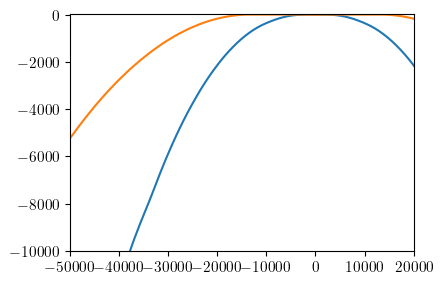

In [66]:
u = np.linspace(0, 1, 1000)
plt.plot(lattice_3TeV['x'](u), lattice_3TeV['y'](u))
plt.plot(lattice_10TeV['x'](u), lattice_10TeV['y'](u))
plt.xlim(-500e2, 200e2)
plt.ylim(-100e2, 10)
# plt.colorbar()

In [21]:
lattice_10TeV

{'x': <scipy.interpolate._interpolate.interp1d at 0x1695afc00>,
 'y': <scipy.interpolate._interpolate.interp1d at 0x1695afe30>,
 's': <scipy.interpolate._interpolate.interp1d at 0x1695afe80>,
 't': <scipy.interpolate._interpolate.interp1d at 0x1695afed0>,
 'angle_of_central_p': <scipy.interpolate._interpolate.interp1d at 0x1695aff70>,
 'beamsize_x': <scipy.interpolate._interpolate.interp1d at 0x1695affc0>,
 'beamsize_y': <scipy.interpolate._interpolate.interp1d at 0x1695d8050>,
 'beamdiv_x': <scipy.interpolate._interpolate.interp1d at 0x1695d80a0>,
 'beamdiv_y': <scipy.interpolate._interpolate.interp1d at 0x1695d80f0>,
 'dispersion_Dx': <scipy.interpolate._interpolate.interp1d at 0x1695d8140>,
 'dispersion_Dpx': <scipy.interpolate._interpolate.interp1d at 0x1695d8190>,
 'inv_s': <scipy.interpolate._interpolate.interp1d at 0x1695d81e0>}

(0.001, 2.0)

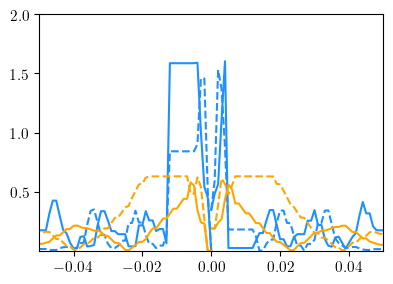

In [81]:
u = np.linspace(0, 1, 1000)
plt.plot(u, lattice_10TeV['beamsize_x'](u), color='dodgerblue')
plt.plot(u, lattice_10TeV['beamsize_y'](u), color='dodgerblue', ls='--')
plt.plot(u, lattice_3TeV['beamsize_x'](u), color='orange')
plt.plot(u, lattice_3TeV['beamsize_y'](u), color='orange', ls='--')

plt.plot(-u, lattice_10TeV['beamsize_x'](u)[::-1], color='dodgerblue')
plt.plot(-u, lattice_10TeV['beamsize_y'](u)[::-1], color='dodgerblue', ls='--')
plt.plot(-u, lattice_3TeV['beamsize_x'](u)[::-1], color='orange')
plt.plot(-u, lattice_3TeV['beamsize_y'](u)[::-1], color='orange', ls='--')


# plt.yscale('log')
plt.xlim(-0.05, 0.05)
plt.ylim(1e-3,2)

(0.0, 0.05)

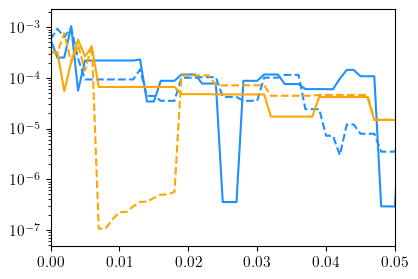

In [55]:
# plt.plot(lattice_10TeV['s'](u), lattice_10TeV['beamdiv_x'](u), color='dodgerblue')
# plt.plot(lattice_10TeV['s'](u), lattice_10TeV['beamdiv_y'](u), color='dodgerblue', ls='--')
# plt.plot(lattice_3TeV['s'](u), lattice_3TeV['beamdiv_x'](u), color='orange')
# plt.plot(lattice_3TeV['s'](u), lattice_3TeV['beamdiv_y'](u), color='orange', ls='--')

plt.plot(u, lattice_10TeV['beamdiv_x'](u), color='dodgerblue')
plt.plot(u, lattice_10TeV['beamdiv_y'](u), color='dodgerblue', ls='--')
plt.plot(u, lattice_3TeV['beamdiv_x'](u), color='orange')
plt.plot(u, lattice_3TeV['beamdiv_y'](u), color='orange', ls='--')

plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 0.05)


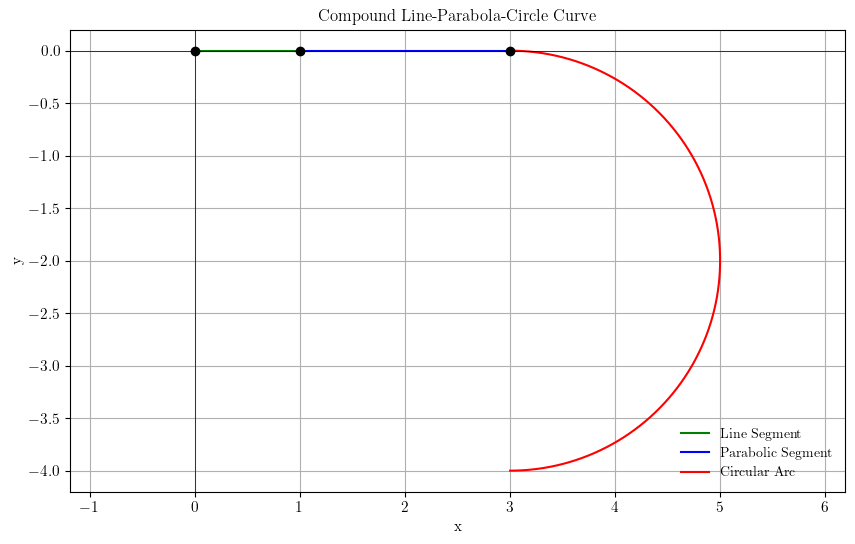

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compound_curve(P0, L, Lq, radius, num_points=100, n_degree=2, coeff=0.1):
    # Straight Line Calculation
    direction = np.array([1, 0])  # Starting with a horizontal direction
    P1 = P0 + direction * L

    vertex = P1
    parabola_x = np.linspace(0, Lq, num_points)
    parabola_y = -coeff * parabola_x**n_degree
    parabolic_points = np.column_stack((P1[0] + parabola_x, P1[1] + parabola_y))

    # Transition point coordinates (end of parabola, start of circle)
    P2 = parabolic_points[-1]

    # Circle center should be such that the tangent at P2 matches parabola's tangent
    tangent_slope = -(n_degree) * coeff * parabola_x[-1]**(n_degree-1)
    tangent_angle = np.arctan(tangent_slope)

    # Assume P2 is on the circle and we know its slope
    theta_start = tangent_angle+np.pi/2  # Start from this
    center = P2 - radius * np.array([np.cos(theta_start), np.sin(theta_start)])

    # Define the arc itself
    theta_end = -theta_start
    theta_arc = np.linspace(theta_start, theta_end, num_points)
    arc_points = np.zeros((num_points, 2))
    arc_points[:, 0] = center[0] + radius * np.cos(theta_arc)
    arc_points[:, 1] = center[1] + radius * np.sin(theta_arc)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot([P0[0], P1[0]], [P0[1], P1[1]], 'g-', label='Line Segment')
    plt.plot(parabolic_points[:, 0], parabolic_points[:, 1], 'b-', label='Parabolic Segment')
    plt.plot(arc_points[:, 0], arc_points[:, 1], 'r-', label='Circular Arc')

    plt.scatter(*zip(P0, P1, P2), color='black', zorder=5)
    plt.title('Compound Line-Parabola-Circle Curve')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Example usage
start_point = np.array([0, 0])
line_length = 1
parabolic_length = 2
circle_radius = 2

plot_compound_curve(start_point, line_length, parabolic_length, circle_radius, n_degree=5, coeff=0.)

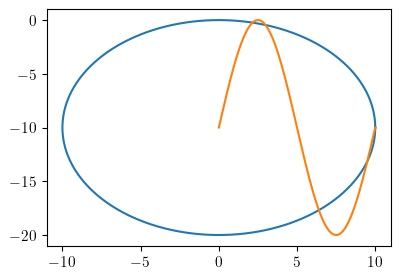

In [121]:
s = np.linspace(0, 1, 1000)
R = 10
plt.plot(R*np.cos(2*np.pi*s), R*np.sin(2*np.pi*s)-R)

plt.plot(R*s, R*np.sin(2*np.pi*s)-R)

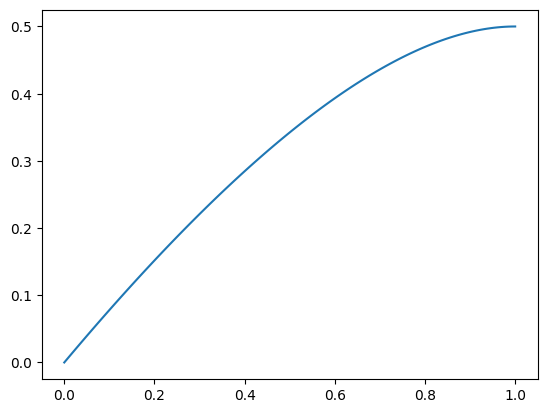

In [22]:
x = np.linspace(0,1,100)
plt.plot(*curve.evaluate_multi(x))